In [232]:
#basic libraries
import pandas as pd
import numpy as np
from collections import Counter

#file saving and format
import pickle
import ast

#SVD method
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#our functions
import functions  as fn

In [2]:
#Useful functions to save and load files in pickle format
def save_dict(obj, name ):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(f'{name}.pickle', 'rb') as f:
        return pickle.load(f)

## Import Data

In [3]:
data = pd.read_csv('Reviews.csv', usecols = ['ProductId','Summary','Text'])

In [4]:
data.head()

ProductId                Summary  \
0  B001E4KFG0  Good Quality Dog Food   
1  B00813GRG4      Not as Advertised   
2  B000LQOCH0  "Delight" says it all   
3  B000UA0QIQ         Cough Medicine   
4  B006K2ZZ7K            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...

In [5]:
#an example of a text that we will have to analyze
data.Text[6745]

"I love juice and I love carbonated beverages, but it is difficult to see this product having a long retail life.<br /><br />Essentially, this is a good drink that doesn't really do anything well.<br /><br />It doesn't taste good enough to be a juice replacement--and is there really a need for a juice replacement?  It might have limited value in camping situations or during other times where small cans make better travelers.<br /><br />It's not exactly a post-workout recovery drink.  Juice would be better.  Minute Maid juice, for instance, has less sugar and carbohydrates, even though Switch doesn't add any sugar.  And there are plenty of other juices that have more nutrients, including Calcium and other vitamins and supplements, including potassium.  So, it's less healthy than most juices.<br /><br />Switch isn't exactly a diet soda because of the natural sugar content comapared to zero sugar in diet drinks.<br /><br />As a regular alternative to sugared soda, it tastes good, but ther

# Analysis of the dataset

In [6]:
print(f'number of unique products: {len(data.ProductId.unique())} \nnumber of total rows in the dataset: {data.shape[0]}')

number of unique products: 74258 
number of total rows in the dataset: 568454


In [7]:
data.groupby('ProductId').count()

Summary  Text
ProductId                
0006641040       37    37
141278509X        1     1
2734888454        2     2
2841233731        1     1
7310172001      173   173
...             ...   ...
B009UOFTUI        1     1
B009UOFU20        1     1
B009UUS05I        1     1
B009WSNWC4        1     1
B009WVB40S        1     1

[74258 rows x 2 columns]

In [8]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Summary    568427 non-null  object
 2   Text       568454 non-null  object
dtypes: object(3)
memory usage: 13.0+ MB


## 1. Preprocessing

The first step in the analysis is the **pre-processing stage**. This  refers to the series of operations that must be done to the text so that it's easier to analyze. The pre-processing part contains the following parts:
- **Corpus tokenization**, that dividesthe different texts into individual words.
- **Stop words removal**, which are common words (a, the, not, etc) that bring close to no contribution to the semantic meaning of a text
- **Noise removal** from the texts. This step will remove anything that can’t be recongnized as a english word, such as words with non ASCII symbols, words together with numbers, etc.
- **Stemming**, which reduces a word to it’s root. 
- **lower case and punctuation removal**

`wordlist = data['Text'].apply(lambda text: fn.pre_processing_data(text))`

`data['text_words'] = wordlist`

In [9]:
data.head(10)

ProductId                                        Summary  \
0  B001E4KFG0                          Good Quality Dog Food   
1  B00813GRG4                              Not as Advertised   
2  B000LQOCH0                          "Delight" says it all   
3  B000UA0QIQ                                 Cough Medicine   
4  B006K2ZZ7K                                    Great taffy   
5  B006K2ZZ7K                                     Nice Taffy   
6  B006K2ZZ7K  Great!  Just as good as the expensive brands!   
7  B006K2ZZ7K                         Wonderful, tasty taffy   
8  B000E7L2R4                                     Yay Barley   
9  B00171APVA                               Healthy Dog Food   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  
5  I got a wild hair for taffy and ordered this f...  
6  This saltwater taffy had great flavors and was...  
7  This taffy is so good.  It is very soft and ch...  
8  Right now I'm mostly just sprouting this so my...  
9  This is a very healthy dog food. Good for thei...

`data.to_csv('clean_dataset.csv')`

In [10]:
#to import directly the filtered dataset instead of pre-process everything again
data = pd.read_csv('clean_dataset.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

#to mantain the format of text_words as a list and not as a string
data['text_words'] = data['text_words'].map(ast.literal_eval)

## 2. Create a vocabulary with all the unique words from text_words
In this step we are going to take into account the last column of the dataset that contains the pre-processed words of each review. From this list of words we are going to create a useful dictionary that maps each unique term into an integer

`dictionary = fn.build_dictionary(data)`   -    to build

`save_dict(dictionary,'dictionary')` - to save

In [11]:
dictionary = load_obj('dictionary')   #to load it back

In [12]:
len(dictionary)

109234

## 3. For every unique product ID combine the list of words from different reviews together 
We noticed in our first analysis that the number of unique products is much smaller than the number of rows in our dataframe. We so concluded that there were different reviews written by different users that referred to the same exact product. We decided to group all these reviews together by creating a dictionary that will be saved and then recalled as **reviews_per_product** that has for:
- **keys** the product ID
- **values** a list of pre-processed words from all the different reviews of the same product

We will, as first thing, create two different lists: one that contains all the productsID of each row of the original dataset, and one, more important, that contains only the ID's of the unique products

In [13]:
products = list([data.ProductId[i] for i in range(len(data))])
unique_products = list(dict.fromkeys(products))

In [14]:
print(len(products))
print(len(unique_products))

568454
74258


`new_data = fn.union_of_reviews_for_same_product(unique_products, data)` - to build

`save_dict(new_data,'new_data')` - to save

In [15]:
reviews_per_product = load_obj('new_data') #to load

Going on with our initial analysis of the dataset that aims to prepare a final output that will be convenient for the implementation of the K-Means algorithm, we want to calculate the frequence of each word for each productID

In [16]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

And then, we will use it to obtain the absolute frequence of each unique word, that we will save in a dictionary called **frequencies**

`freq = fn.frequency(dictionary,frequency_of_word)`

`save_dict(freq,'frequencies')` - to save

In [17]:
frequencies = load_obj('frequencies') #to load

Now we have all the elements to make some considerations: we noticed that, from the original vocabulary, we have **109234 unique words**. For the implementation of the algorithm, these words are too many. We want to find a way to reduce the number of words to consider by selecting only the ones that will be actually significant in the clusterization of the products

In [18]:
print('max: ',max(list(frequencies.values())))
print('min: ',min(list(frequencies.values())))

max:  288508
min:  1


In order to do so, we first filtered the list of words by removing the one that have a really low frequence (<20) since are words too unusual, technical or maybe they could be wrong words, with spelling mistakes, hence, with no meaning. At the same time we want to remove words with a very high frequence (>200000) since these words are too common and will not help in dividing the products into similar groups, which is our final goal.

In [19]:
output = fn.filter_words(frequencies)
useful_words = output[0] 
frequent_words = output[1]

In [20]:
dictionary_filtered = fn.new_dictionary(useful_words)

By doing this we will reduce the length of the dictionary, that will contain all the different unique words found inside the reviews, from `len(dictionary) = 109234 ` to `len(useful_words) = 14783 `

In [21]:
frequent_words

['product', 'good', 'tast', 'flavor', 'like']

As we can see above, all the words with very high frequencies are very common words, so they will not be useful in the determination of the cluster in which a certain review will belong to.

## 4. Matrix product/word of occurrences

Now we want to create a matrix that will have the following structure:
- each column will represent one word from the list **useful_words**
- each row represents a different unique product id

Each **cell** of the matrix will represent the frequence of that certain word inside the reviews of that certain product

In [22]:
matrix = fn.get_occurrency_matrix(unique_products,dictionary_filtered,frequency_of_word)

In [23]:
matrix.shape

(74258, 14783)

## 5. Singular Value Decomposition  

In order to further reduce the dimentionality of our paramteres (words) we want to apply the **SVD Method**. This method basically operates a principal component analysis which is more specific for sparse matices, as the one that we have. When calling this function we need to specify the number of components that will explain a certain ammount o variability of our dataset. In general we should select this *n_components* such that the explained variability is still above 60 % of the total one. We have tried different values and found that 70 was a good balance between dimensionality reduction and percentage of explained variability.

In [24]:
svd = TruncatedSVD(n_components = 70,n_iter=3, random_state=42)
svd.fit(matrix)

TruncatedSVD(n_components=70, n_iter=3, random_state=42)

In [25]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance: {}%".format(int(explained_variance * 100)))

Explained variance: 88%


Here we see how the output of this analysis is structured: it is an array with `length = n_components` and for each element we have the coefficients associated to the 14783 original variables. Therefore each dimension is a linear combination of input features. We decied to filter varibles by ignoring those that had a contribution to any dimension inferior to 0.01.

In [26]:
print(len(svd.components_[0]))
print(len(svd.components_))
svd.components_

14783
70


array([[ 2.61458657e-04,  2.08688090e-05,  1.67157890e-02, ...,
         1.14701734e-05,  6.34622146e-04,  4.84766436e-05],
       [-2.87695443e-04, -1.80610947e-05,  2.00614839e-02, ...,
        -1.47533969e-05, -4.50031959e-04, -4.77095308e-05],
       [ 2.00412741e-04, -8.62397141e-05,  1.21800044e-03, ...,
         3.68290150e-06,  2.11589385e-04, -2.51540206e-05],
       ...,
       [-1.45499178e-03,  1.30557199e-05,  2.03228666e-02, ...,
         1.84089989e-04, -1.16989676e-03, -4.51433893e-04],
       [-4.33034152e-04, -1.54894184e-05, -1.49323213e-03, ...,
        -5.42299589e-05, -1.80393658e-03, -3.72238502e-03],
       [-8.52094510e-05,  5.30261948e-05,  6.03304260e-03, ...,
        -8.40015351e-05,  1.59359845e-03,  4.31270772e-03]])

In [27]:
components = svd.components_
features = useful_words

In [28]:
relevant_words = fn.get_relevant_words(components, features)
print(relevant_words)

['treat', 'squeez', 'anyth', 'ounc', 'cereal', 'normal', 'com', 'weight', 'buy', 'dri', 'pop', 'train', 'black', 'gp', 'delici', 'mean', 'least', 'coconut', 'piec', 'hour', 'acid', 'maker', 'carri', 'organ', 'side', 'senseo', 'ground', 'make', 'especi', 'receiv', 'perfect', 'hous', 'sinc', 'qualiti', 'ginger', 'ad', 'similar', 'drinker', 'can', 'medium', 'gave', 'size', 'line', 'save', 'also', 'cost', '10', 'easili', 'meal', 'kind', 'peopl', 'food', 'wast', 'decid', 'rather', 'smell', 'worth', 'half', 'bag', 'wish', 'satisfi', 'blend', 'crunchi', 'morn', 'sauc', 'vanilla', 'case', 'day', 'quickli', 'smooth', 'better', 'favorit', 'packet', 'start', 'addit', 'everyon', 'singl', 'took', 'wife', 'issu', 'sweet', 'tea', 'set', 'weak', 'pour', 'littl', 'nutrit', 'wonder', 'mani', 'gluten', 'bought', 'artifici', 'effect', 'healthi', 'test', 'consid', 'everyth', 'husband', 'brew', 'believ', 'roast', 'tri', 'let', 'bake', 'pick', 'origin', 'made', 'nice', 'sugar', 'much', 'right', 'marley', 'ex

After selcting the most relevant words out of the total of unique words found, we have to update the dictionary **reviews_per_product** which associates a list of preprocessed words found in all the reviews concerning the same product, to the ProductID corresponding. The list now should contain only the words that were found in the reviews **AND** are inside the list of **relevant_words** that we extracted

In [29]:
#to update the dictionary reviews_per_product
for key, value in reviews_per_product.items():
    reviews_per_product[key] = [word for word in value if word in relevant_words]

We need of course to calculate again the frequency of those words...

In [30]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

... And create a final dictionary that maps those relevant words into integers

In [31]:
final_dictionary = fn.new_dictionary(relevant_words) 

## 6. Calculate Tf-Idf Scores for each word inside the reviews of a product ID

`tf_score = fn.tf(frequency_of_word,reviews_per_product)`

`idf_score = fn.idf(relevant_words,frequency_of_word,reviews_per_product)`

`tf_idf_scores = fn.tf_idf_score(tf_score,idf_score,reviews_per_product)`

`save_dict(tf_idf_scores,'tf_idf_scores')` - to save

In [32]:
tf_idf_scores = load_obj('tf_idf_scores')   #to load

In [33]:
#an example of the final output
tf_idf_scores[0]

{'bought': 0.10921,
 'sever': 0.16207,
 'can': 0.22032,
 'dog': 0.19854,
 'food': 0.11283,
 'found': 0.11182,
 'qualiti': 0.13776,
 'look': 0.10748,
 'meat': 0.22029,
 'smell': 0.17404,
 'better': 0.20642}

## 7. Creation of the final dataframe that consider the TF-IDF scores and will be used for the implementation of K-Means :
We will first initialize a matrix that will have as many rows as the number of unique product ID's that we have and as many columns as the number of relevant words that we found.

For each product we will assign a score to each word:
- 0 if the word is not found inside the list of words of the reviews of that product
- tf-idf score of that word otherwise

In [34]:
product_vector = fn.get_tfidf_scores_matrix(unique_products,relevant_words, tf_idf_scores, final_dictionary)

In [35]:
#trial to see if the above operation worked

indices = (np.where(product_vector[0] != 0))[0]
print(indices,'\n')

for elem in indices:
    for key in final_dictionary.keys():
        if final_dictionary[key] == elem:
            print(key)

print('\n',reviews_per_product[unique_products[0]])           

[ 33  38  51  55  70  90 115 192 245 314 322] 

qualiti
can
food
smell
better
bought
sever
look
dog
found
meat

 ['bought', 'sever', 'can', 'dog', 'food', 'found', 'qualiti', 'look', 'meat', 'smell', 'better', 'better']


Finally, we can convert the result into a dataframe:

In [36]:
d = pd.DataFrame(product_vector, index = unique_products, columns = relevant_words)
d

treat  squeez    anyth  ounc   cereal  normal  com  weight  \
B001E4KFG0  0.00000     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B00813GRG4  0.00000     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B000LQOCH0  0.32101     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B000UA0QIQ  0.00000     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B006K2ZZ7K  0.04377     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
...             ...     ...      ...   ...      ...     ...  ...     ...   
B000H7K114  0.00000     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B001EO7N10  0.00000     0.0  0.02062   0.0  0.00000     0.0  0.0     0.0   
B003S1WTCU  0.00000     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B004I613EE  0.14093     0.0  0.00000   0.0  0.00000     0.0  0.0     0.0   
B001LR2CU2  0.00000     0.0  0.00000   0.0  0.83609     0.0  0.0     0.0   

                buy  dri  ...  long  take  bite  instead    2      got  \
B001E4KFG0  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B00813GRG4  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B000LQOCH0  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B000UA0QIQ  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.16986   
B006K2ZZ7K  0.02103  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.03474   
...             ...  ...  ...   ...   ...   ...      ...  ...      ...   
B000H7K114  0.00000  0.0  ...   0.0   0.0   0.0  0.08114  0.0  0.00000   
B001EO7N10  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B003S1WTCU  0.05140  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B004I613EE  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   
B001LR2CU2  0.00000  0.0  ...   0.0   0.0   0.0  0.00000  0.0  0.00000   

             enough  corn  fine  hard  
B001E4KFG0  0.00000   0.0   0.0   0.0  
B00813GRG4  0.00000   0.0   0.0   0.0  
B000LQOCH0  0.00000   0.0   0.0   0.0  
B000UA0QIQ  0.00000   0.0   0.0   0.0  
B006K2ZZ7K  0.00000   0.0   0.0   0.0  
...             ...   ...   ...   ...  
B000H7K114  0.00000   0.0   0.0   0.0  
B001EO7N10  0.01839   0.0   0.0   0.0  
B003S1WTCU  0.00000   0.0   0.0   0.0  
B004I613EE  0.00000   0.0   0.0   0.0  
B001LR2CU2  0.00000   0.0   0.0   0.0  

[74258 rows x 458 columns]

And we will save it so that we can import only this final step since it contains everything we need for the implementation of the K-Means Algorithm

`d.to_csv('tf_idf_scores_dataframe.csv')` - to save

# K-means

In [37]:
d = pd.read_csv('tf_idf_scores_dataframe.csv')
d.set_index('Unnamed: 0',inplace=True)
d.head()

sweet  bowl  favorit  water  bottom  top  name     soda  say  \
Unnamed: 0                                                                 
B001E4KFG0    0.0   0.0  0.00000    0.0     0.0  0.0   0.0  0.00000  0.0   
B00813GRG4    0.0   0.0  0.00000    0.0     0.0  0.0   0.0  0.00000  0.0   
B000LQOCH0    0.0   0.0  0.00000    0.0     0.0  0.0   0.0  0.00000  0.0   
B000UA0QIQ    0.0   0.0  0.00000    0.0     0.0  0.0   0.0  0.39439  0.0   
B006K2ZZ7K    0.0   0.0  0.03439    0.0     0.0  0.0   0.0  0.00000  0.0   

            wast  ...      etc  run  pay  green  realli  grain  test      got  \
Unnamed: 0        ...                                                           
B001E4KFG0   0.0  ...  0.00000  0.0  0.0    0.0     0.0    0.0   0.0  0.00000   
B00813GRG4   0.0  ...  0.00000  0.0  0.0    0.0     0.0    0.0   0.0  0.00000   
B000LQOCH0   0.0  ...  0.00000  0.0  0.0    0.0     0.0    0.0   0.0  0.00000   
B000UA0QIQ   0.0  ...  0.00000  0.0  0.0    0.0     0.0    0.0   0.0  0.16986   
B006K2ZZ7K   0.0  ...  0.05352  0.0  0.0    0.0     0.0    0.0   0.0  0.03474   

            pill  differ  
Unnamed: 0                
B001E4KFG0   0.0     0.0  
B00813GRG4   0.0     0.0  
B000LQOCH0   0.0     0.0  
B000UA0QIQ   0.0     0.0  
B006K2ZZ7K   0.0     0.0  

[5 rows x 458 columns]

Before applying the algorithm, we need to understand **K**, the number of clusters. This can be determined by the **elbow method**

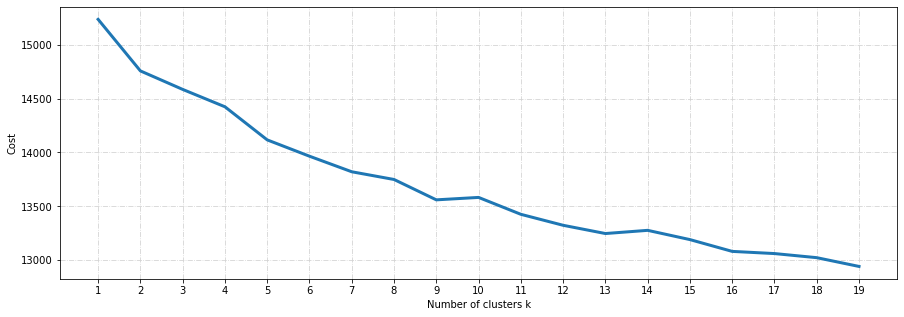

The optimal number of clusters is: 10


In [38]:
k = fn.elbow_method(d)
print(f'The optimal number of clusters is: {k}')

We decided to select the best k using the following condition: we want the minimun number of clusters that explains at least 80% of  the variance of the curve. The variance explained with the best k should be minimum: $(\textrm{variance with } k=1) - [(\textrm{variance with } k = 1) - (\textrm{variance with } k = 20)]*0.8$

In [39]:
#we convert our initial dataframe d into an array for easier computation
vectors = np.array(d)

We first define some functions that will be then recalled inside the proper algorithm: this functions will be useful to determine the initial points of each cluster, compute the distance between each point and each cluster, in order to understand in which cluster that point has to be inserted, and, finally, compute the variance at each iteration of the algorthm in order to understand when the best cluster is achieved.

All these functions were recalled in a main function `k_means` that computes the whole algorithm:

In [55]:
initial_centroids, centroids, clusters, cluster_variance = fn.k_means(vectors,d,k)

INITIALIZATION

our initial centroids are the products:

B001IA99FS
B000U9YPXE
B001MUM3HA
B00434MNNQ
B0051GBKZM
B002ADDQEM
B0015DAEI4
B0078EZQE6
B00022F2A4
B006C1GWXK

iteration 0: cluster variance: 1483.1

ITERATIONS

iteration 1: cluster variance: 1440.7
iteration 2: cluster variance: 1398.9
iteration 3: cluster variance: 1383.5
iteration 4: cluster variance: 1378.4
iteration 5: cluster variance: 1376.0
iteration 6: cluster variance: 1375.0
iteration 7: cluster variance: 1373.6
iteration 8: cluster variance: 1371.5
iteration 9: cluster variance: 1368.3
iteration 10: cluster variance: 1365.7


We know that, when the cluster variance pretty much stabilize, it means that the algorithm has found the best solution: the data points within each cluster stop changing. So, to take into account this phenomenon, we inserted a condition that considers the distance between the variation at step *i* and at step *i-1*, when it goes below a certain limit (that we fixed at 1.0), the algorithm stops.

We can visualize the change of viariance at each iteration from the graph below:

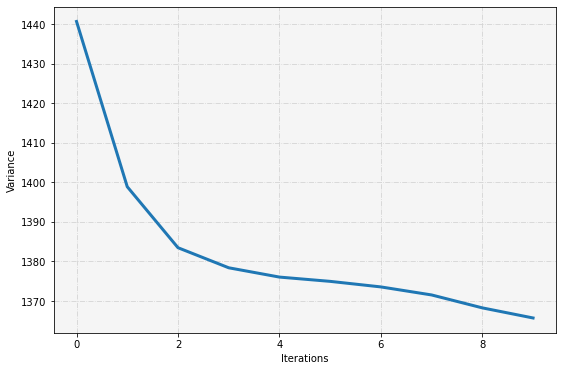

In [56]:
plt.figure(figsize=(9,6))
plt.plot(cluster_variance, linewidth = 3)
plt.grid(color = 'lightgray', linestyle = '-.')
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.show()

We will now create a new dataframe that has only three columns:
1. the **Product ID**
2. the **list of words** associated to the reviews of that specific product
3. the **cluster** in which that product has been assigned from the K-Means algorithm

In [57]:
cluster_list = [cluster for list in clusters for cluster in list]

In [58]:
df = pd.DataFrame(list(reviews_per_product.items()),columns = ['ProductID','list_of_words']) 
df['cluster'] = cluster_list

This new dataframe will be used in the analysis of the clusters, which is the next step of our project

# Analysis of the clusters

Since we can retrieve the productID of the products inside the same cluster, we can now analyze the clusters a little bit deeper.

To do so we will need the new dataframe that we have created **df** and the original dataset **Reviews** that contains more information for each row

In [59]:
data = pd.read_csv('Reviews.csv')
data.drop('Id', axis = 1, inplace = True)
data.head()

ProductId          UserId                      ProfileName  \
0  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### 1. Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a word cloud.

From what we can see in the word clouds below we can infere the following categories for each cluster:
1. Choccolate and sauces
2. Tea and drinks
3. Dog food
4. Spices
5. Cat food
6. Rice and cereals
7. none
8. Nuts
9. Snacks
10. Coffee
 

Most of the clusters actually have words that relate to each other and also suggest a specific category, while cluster 7 have many words that do not specify any category of food. Those products probably clustered on a centroid that had a review related to the quality of the service or the level of satisfaction of a product rather than the product itself. In reality we know that there are a lot of reviews that don't give any specification on the product, for those it's really hard to make any clustring. To support this idea we could analyze how many products fall in this categories and see if there is any difference with other clusters.

Word cloud for cluster: 1


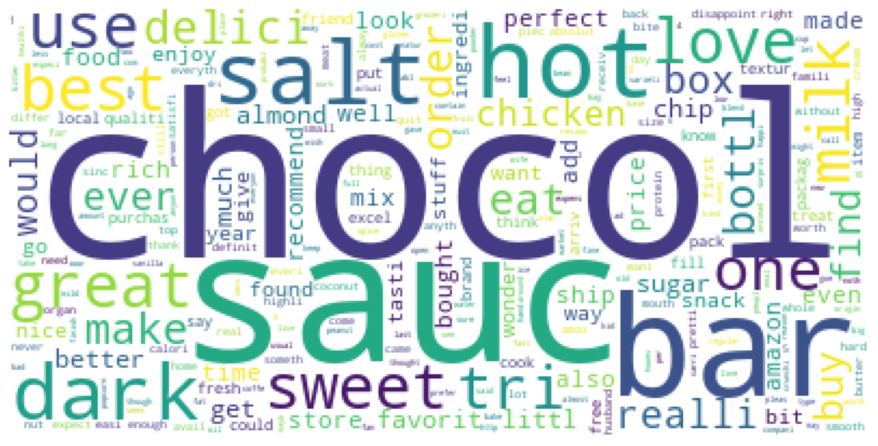

Word cloud for cluster: 2


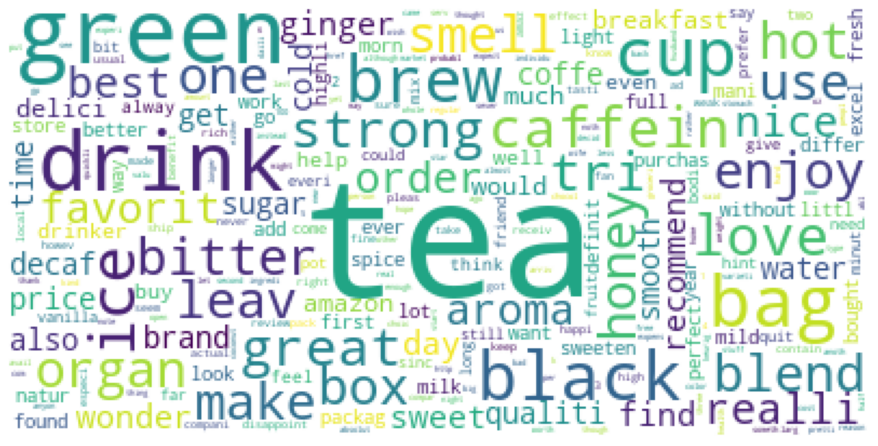

Word cloud for cluster: 3


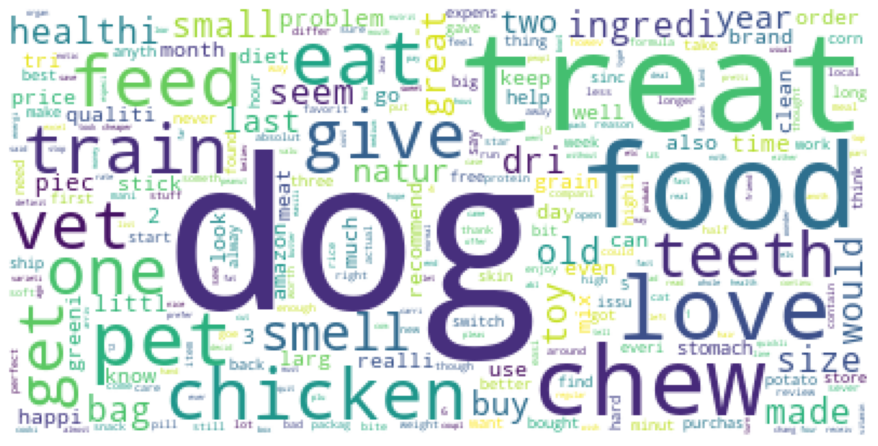

Word cloud for cluster: 4


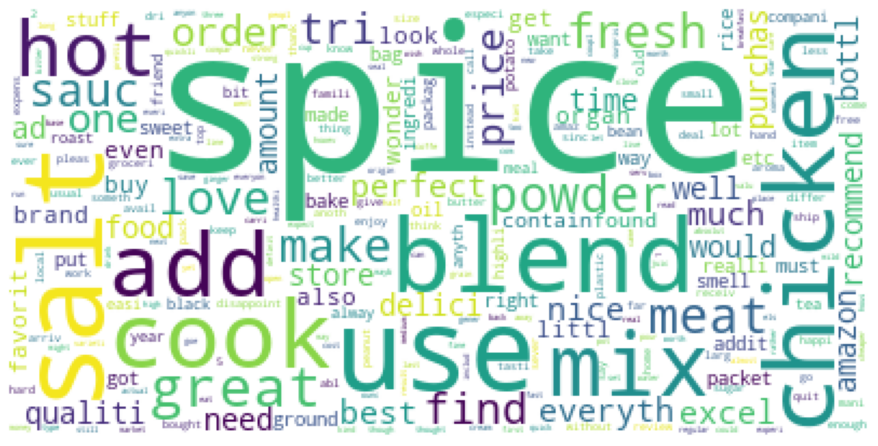

Word cloud for cluster: 5


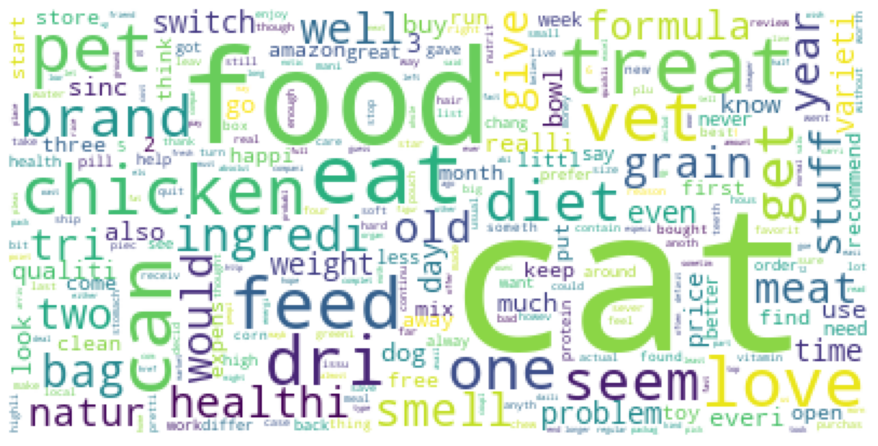

Word cloud for cluster: 6


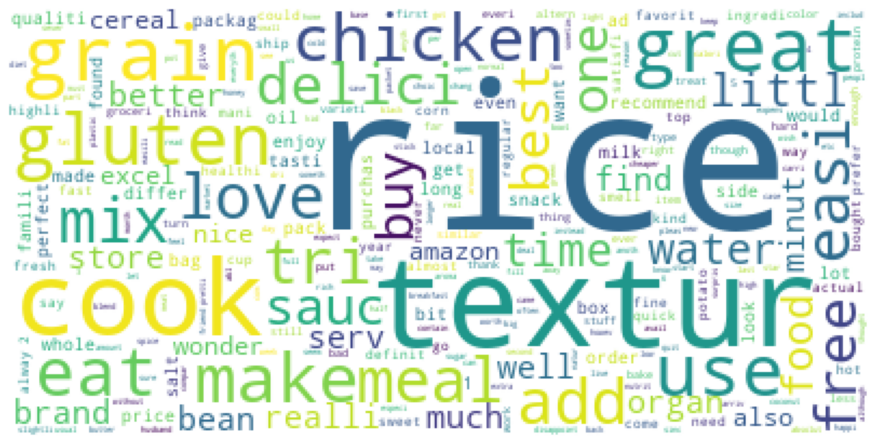

Word cloud for cluster: 7


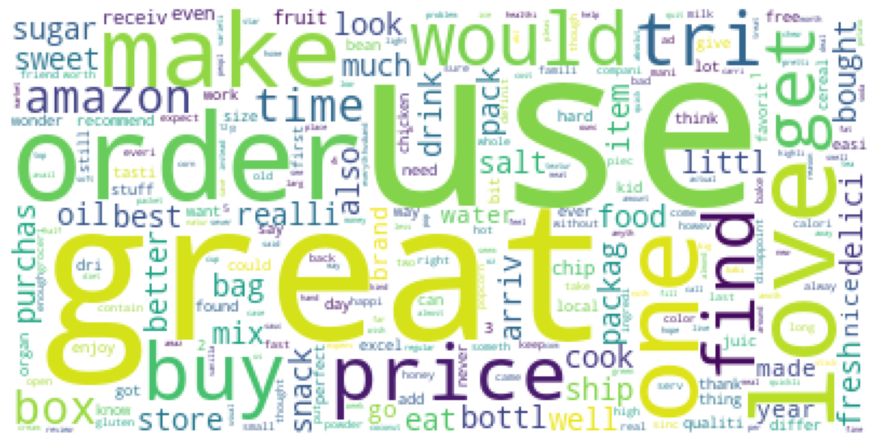

Word cloud for cluster: 8


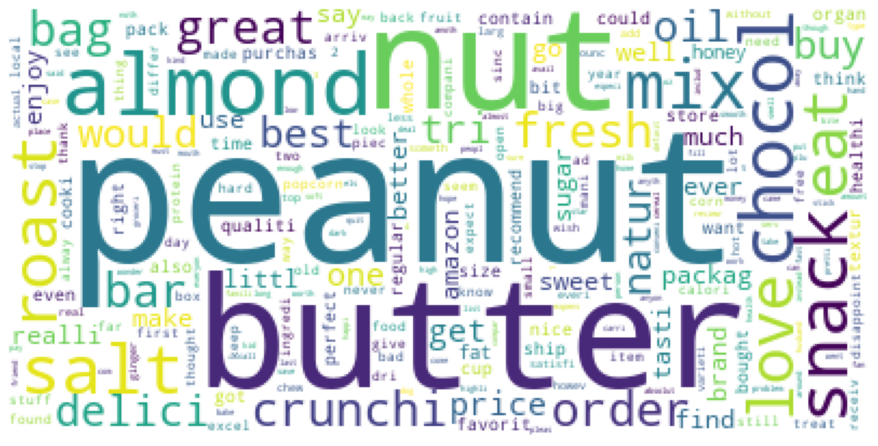

Word cloud for cluster: 9


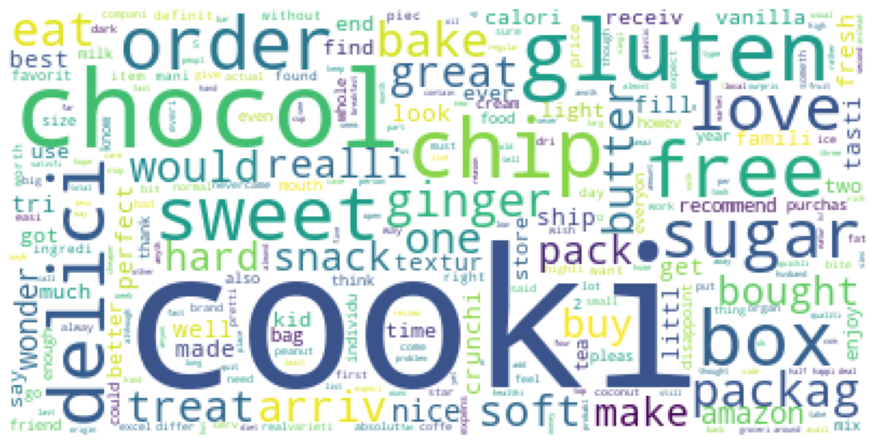

Word cloud for cluster: 10


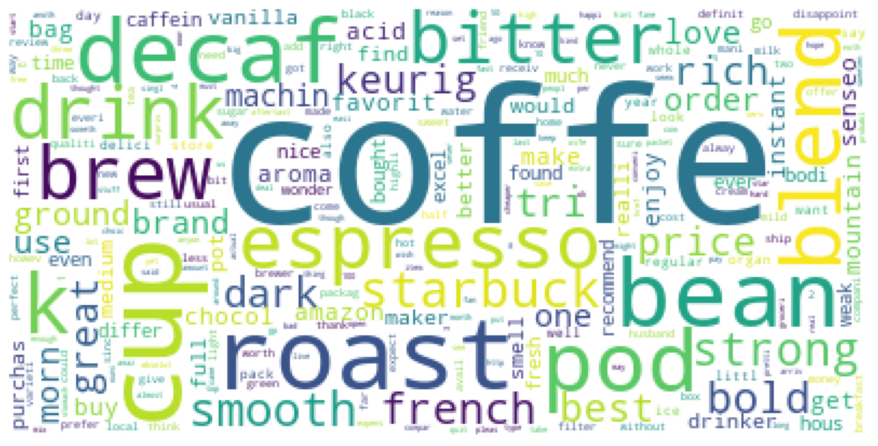

In [60]:
fn.words_cloud(d,k,cluster_list)

### 2. Provide the number of product in each cluster:
To answer this  question we can group by the products based on the cluster they belonged. 

In [61]:
df.groupby('cluster').count()

ProductID  list_of_words
cluster                          
1             5977           5977
2             5329           5329
3             4363           4363
4              838            838
5             1852           1852
6             1209           1209
7            47482          47482
8             1235           1235
9             1436           1436
10            4537           4537

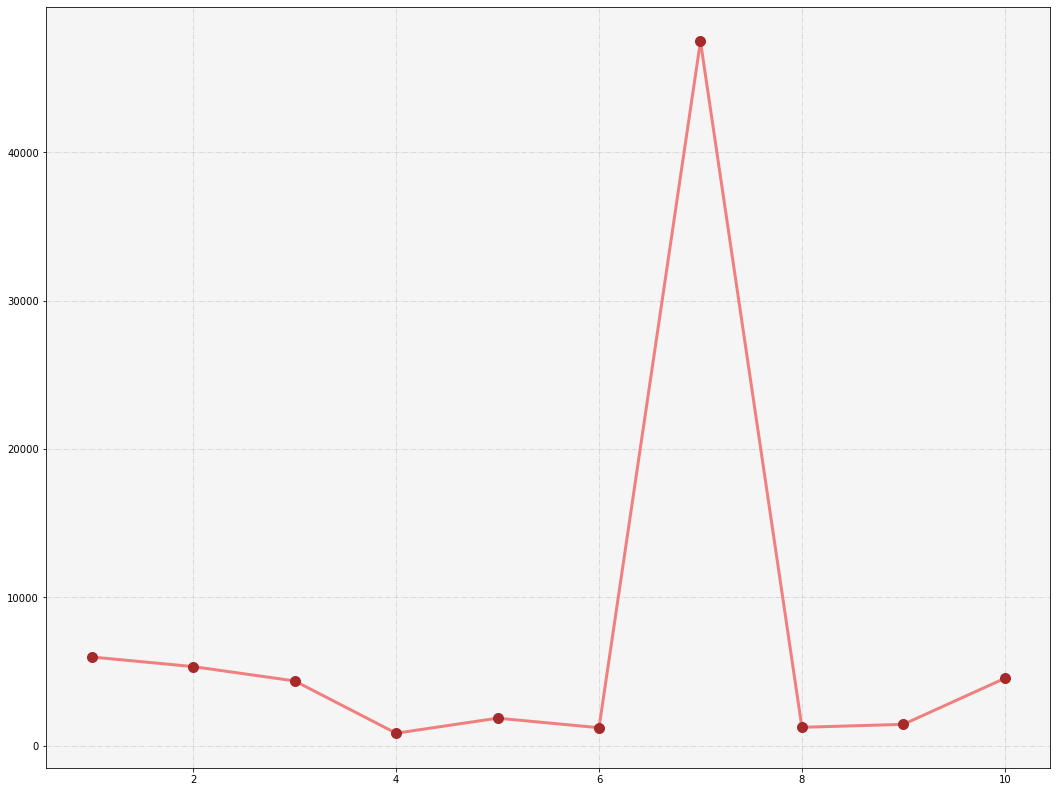

In [62]:
plt.figure(figsize = (18,14))
plt.plot(df.groupby('cluster').ProductID.count(), color = 'lightcoral',linewidth = 3, 
         marker = 'o', markersize = 10, mfc = 'brown', mec = 'brown')
plt.grid(color = 'lightgray', linestyle = '-.')
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.show()

As we can see, the cluster that has the majority of products associated to, is **cluster number 7** which corrresponds to the following product IDs:

In [82]:
df[df.cluster == 7].ProductID

2        B000LQOCH0
3        B000UA0QIQ
4        B006K2ZZ7K
9        B001GVISJM
10       B00144C10S
            ...    
74247    B001FPT1WM
74249    B000NY4SAG
74250    B005ZC0RRO
74252    B006T7TKZO
74257    B001LR2CU2
Name: ProductID, Length: 47482, dtype: object

As we predicted in point 1, cluster 7 is peculiar since none of the words is actually suggesting a product category, on the contrary all words are pretty general and probably are used in the reviews of many different product categories. As a result, many more points are associated to this cluster since the words that are being considered for clusterization are not specific enough.

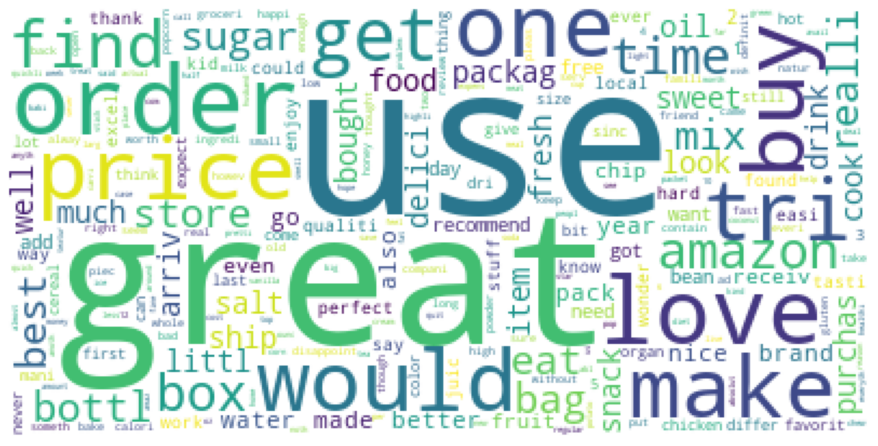

In [83]:
fn.one_word_cloud(7,d)

### 3. Compute the reviews' score distribution in each cluster

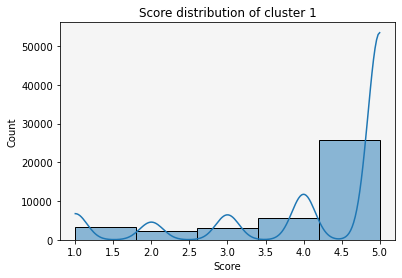

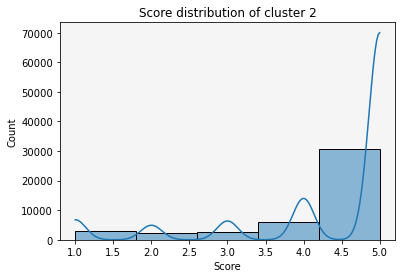

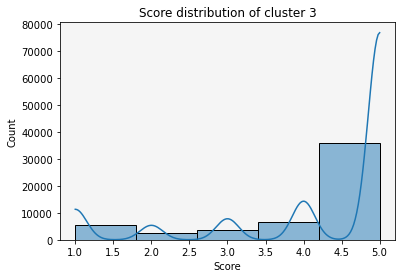

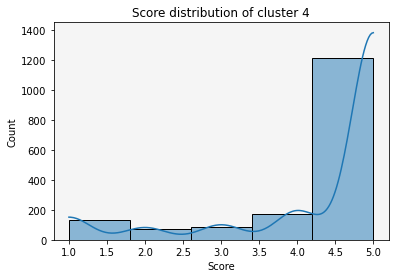

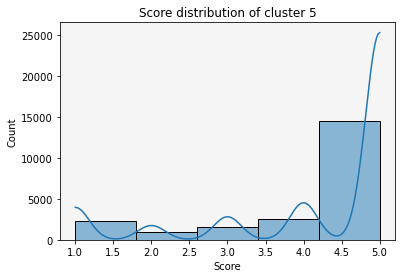

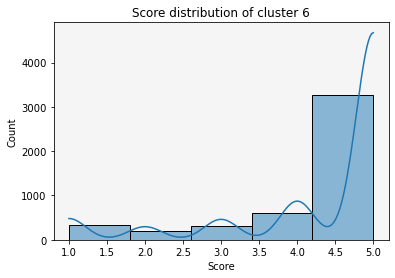

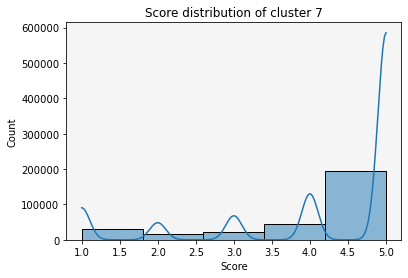

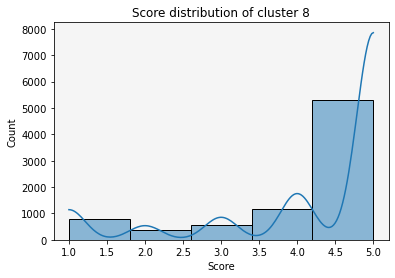

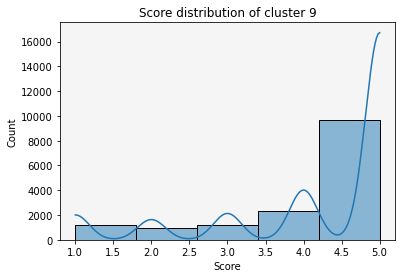

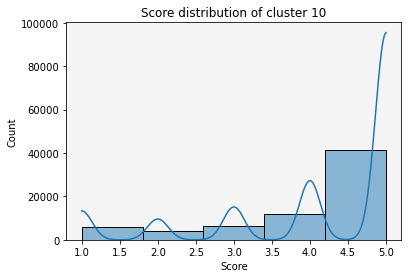

In [65]:
score_means = fn.review_score_distribution(k,df,data)

In [66]:
for i in range(1,len(score_means)+1):
    print(f'mean of scores in cluster {i}: {round(score_means[i-1],3)}')

print(f'\nThe maximum value is: {round(max(score_means),3)} while the minimum is: {round(min(score_means),3)}')

mean of scores in cluster 1: 4.212
mean of scores in cluster 2: 4.328
mean of scores in cluster 3: 4.21
mean of scores in cluster 4: 4.349
mean of scores in cluster 5: 4.185
mean of scores in cluster 6: 4.321
mean of scores in cluster 7: 4.161
mean of scores in cluster 8: 4.206
mean of scores in cluster 9: 4.2
mean of scores in cluster 10: 4.131

The maximum value is: 4.349 while the minimum is: 4.131


As we can see, although the number of products in each cluster in extremely different, the mean of the scores that the users give to the products in each cluster is basically the same, and is a very high value, always greater than 4

### 4. Get the number of unique users writing reviews in each cluster 

In [67]:
fn.number_of_unique_users(k, df, data)

number of unique users writing reviews in cluster 1: 23684
number of unique users writing reviews in cluster 2: 22908
number of unique users writing reviews in cluster 3: 20799
number of unique users writing reviews in cluster 4: 1510
number of unique users writing reviews in cluster 5: 8710
number of unique users writing reviews in cluster 6: 4209
number of unique users writing reviews in cluster 7: 166544
number of unique users writing reviews in cluster 8: 5919
number of unique users writing reviews in cluster 9: 7423
number of unique users writing reviews in cluster 10: 31876


## Plotting results

In [212]:
palette = sns.color_palette('Set1') + sns.color_palette('Set3') 
cm =  LinearSegmentedColormap.from_list('cols', palette, N=10)
grouped_df = df.groupby('cluster')

#### PCA in 2 dimentions 
Here we want to explain the distance among all points by taking the first two components from PCA.

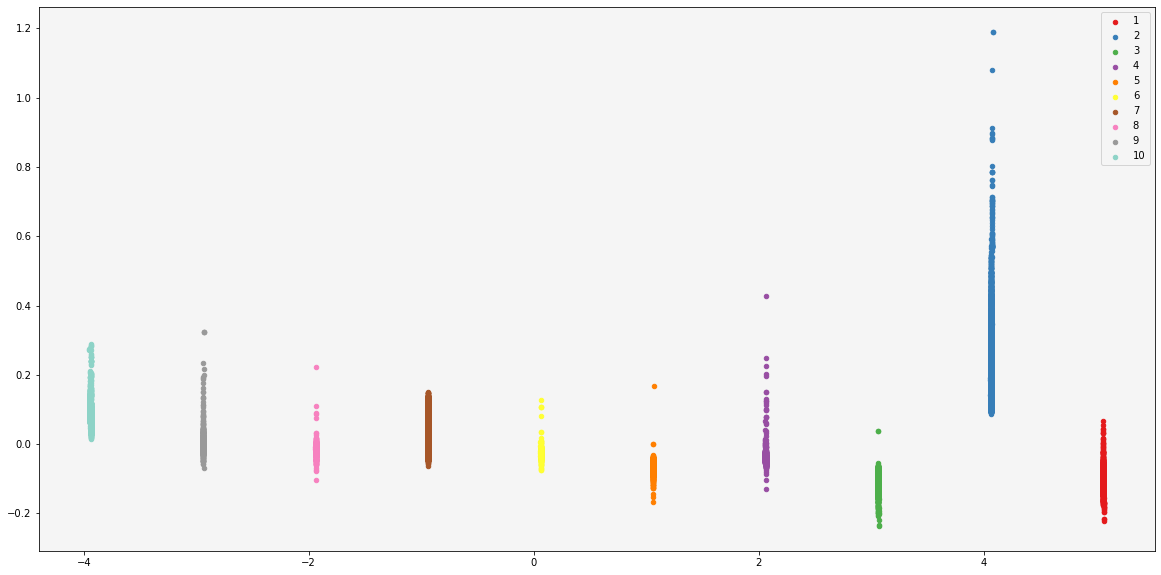

In [213]:
'''coordinates'''
pca_2d = PCA(n_components=2)
X2d = pca_2d.fit_transform(d)
''' Plot '''
plt.figure(figsize=(20,10))
for cluster, col in zip(range(k), palette):
    i = grouped_df.get_group(cluster+1).index
    plt.scatter(X2d[i][:,0], X2d[i][:,1], color=col, s =20,label= cluster+1)
plt.legend()
plt.show()

In this plot we considered the first two components to describe our dataframe and we plotted each cloud according to the 2D coordinates produced by the PCA for each point. From here we can appreciate how some clusters, for example cluster 7, 3 and 1, have few or none outliers. This may suggest that the clustering of these products strongly depends on few variables (maybe two words).

#### PCA in 3 dimentions
Here we repeat the same approach as before but now using three components to explain our data. 

In [214]:
clusters_vector = [x[0] for x in clusters]

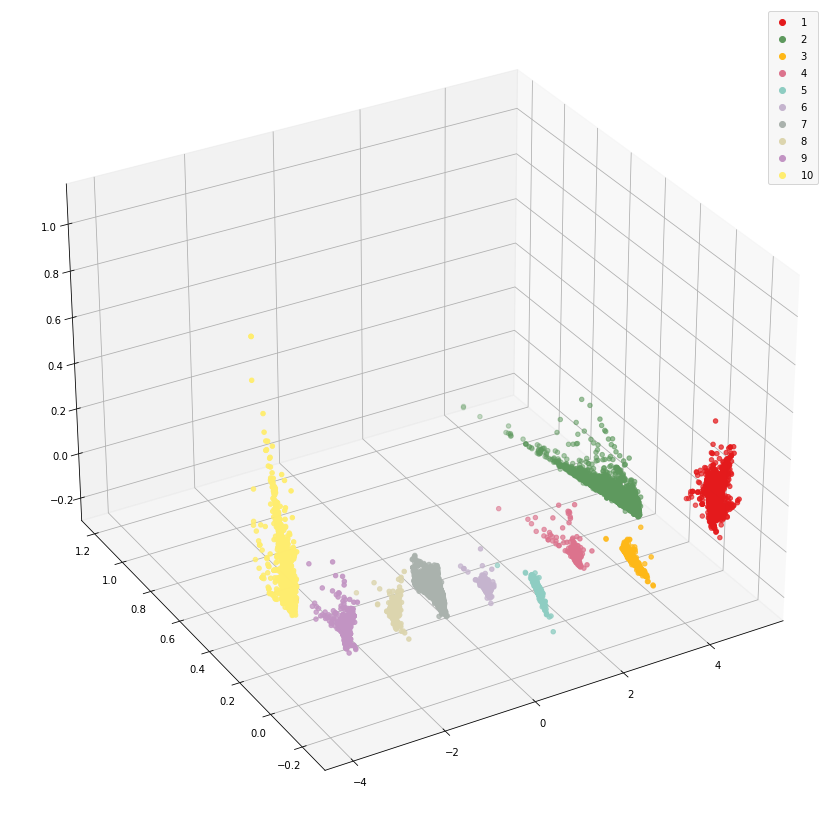

In [236]:
'''coordinates'''
pca_3d = PCA(n_components=3)
X3d = pca_3d.fit_transform(d)

'''plot'''
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")
scatter = ax.scatter3D(X3d[:,0],X3d[:,1],X3d[:,2], c=clusters_vector,cmap=cm ,s = 20)
ax.legend(*scatter.legend_elements())
ax.view_init(elev=30., azim=(240))
ax.set_facecolor('white')
plt.show()

In this plot we have used the first three principal components from our tf-idf dataframe. We associate a color to each point depending on the cluster they have been associated to by our k-means algorithm. With 3 components we can already see that the coloring is actualy strongly coherent with their point coordinate in most cases. Cluster 10 and cluster 2 are those whose variance is more poorly explained by three components. This results is actually consistent with the wordcloud plot since for those two clusters a low of words had an avarage size, meaning that more variables were contributing in defyning the cluster. 

## Comparing to built in k-means ++
Here we compare the built in K-means++ function to the one we have implemented considering the number of clusters and the inertia of these two clusterizazion. 

In [216]:
kmeans1 = KMeans().fit(d)
clusters_vector2 = list(kmeans1.labels_)

In [224]:
print('### Built-in K-means ++ ###')
print('Number of clusters:' ,len(kmeans1.cluster_centers_))
print('The WSS score is',kmeans1.inertia_, ' \n')
print('### Implemented K-means with random inizialization ###')
print('Number of clusters:' ,k)
print('The WSS score is ',sum(cluster_variance))

### Built-in K-means ++ ###
Number of clusters: 8
The WSS score is 15205.0423260959  

### Implemented K-means with random inizialization ###
Number of clusters: 10
The WSS score is  13831.435260951845


The first important observation that we should make is that according to the way in which we decided to pick the optimal nuber of clusters, we should have 10 clusters, while the kmeans++ only build 8 clusters. Of course this difference is also reflected in the WSS score since it is higher in the kmeans++ rather then in our implementation. Another factor that could be responsible for this result is that in our algorithm we used the distance between one point and the centroids as the only parameter defyining the clustering, so we are sure that we are actually minimizing the wss score. On the other hand the built-in k-means also condsidered the mean distance of a point to all the other points in the cluster, which for sure makes the clusterization less sensivitve to an unefficient centroid selection but may increase the overall WSS score.

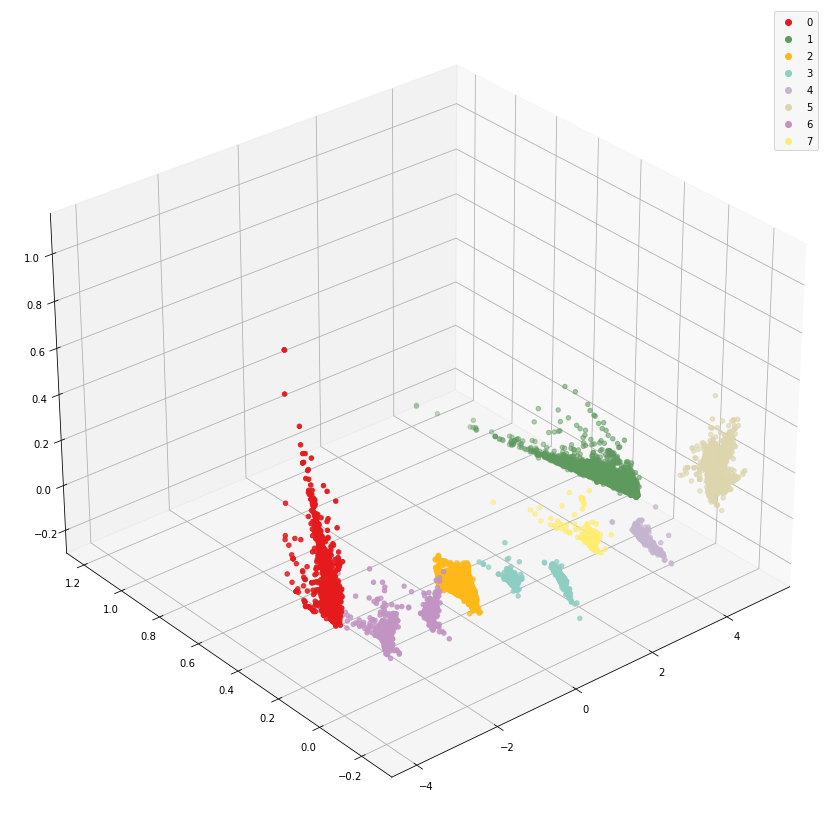

In [237]:
'''coordinates'''
pca_3d = PCA(n_components=3)
X3d = pca_3d.fit_transform(d)

'''plot'''
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")
scatter2 = ax.scatter3D(X3d[:,0],X3d[:,1],X3d[:,2], c=vector1, cmap=cm , s=20)
ax.legend(*scatter2.legend_elements())
ax.view_init(elev=30., azim=(230))
ax.set_facecolor('white')
plt.show()

By comparing this plot with the one obtained from our clustering we can see that of course some components are associated to the same cluster since we only have 8, the clusters that are considered as a unique cluster are in this case cluster 8-9 (new 6) and 5-6 (new 3).

## Clustering on distance matrix 
Our first idea for the clustering was to build a distance matrix of all products but this approach was not convenient given the large number of elements we had to store. However we report the approach we could use if we had a dataset with less elements. This approach whould allow to save time when running the kmeans since we only need to access the distance between any two points rather than calculating it each time. This approach also allows to cluster not only according to the distance from a point to the centroid but also according to the mean distance of a specific point to any other point in that cluster. \
To explore more this approach we implemented the elbow method and the silhouette method for optimal k estimation, also we wanted to see how radom inizialization influences the clustering itself. For this purpose we will take into account only the first 5000 products and compute the distance matrix. \

`matrix = functions.build_distance_matrix(final_dictionary)` - to build dictionary \
`matrix_df = pd.DataFrame(matrix)` - covert to df \
`matrix_df.to_csv('matrix.csv', index=False, header=False) ` - to save

In [80]:
'''Load without running'''
matrix_df = pd.read_csv('matrix.csv',header=None)
matrix_array = matrix_df.to_numpy()

### K-means
K-means algorithm that is inizialized with random points and a number of clusters k. It returns a dictionary where the keys are the cluster ids, the ids of the random centroids, the clusters id associated to each centroid and the within cluster squared score.

### Evaluating optimal number of clusters: 
#### Elbow method: 
- Compute clustering algorithm for different values of k.
- For each k, calculate the total within-cluster sum of square (wss).
- Plot the curve of wss according to the number of clusters k.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters. The wss measures the squared average distance of all the points within a cluster to the cluster centroid. To calculate WCSS, you first find the Euclidean distance between a given point and the centroid to which it is assigned. You then iterate this process for all points in the cluster, and then sum the values for the cluster and divide by the number of points. Finally, you calculate the average across all clusters. 
#### Silhouette method:
- We vary k from 1 to 20 clusters.
- For each k, calculate the average silhouette of observations by taking the avarage silhouette score for each point, which is an indicator of how much a point is close to point inside its cluster rather than point outside its cluster.
-  We plot the avg silhouette according to the number of clusters k.
- The location of the maximum is considered as the appropriate number of clusters.
#### Optimized k-means inizializations
By combining the two results for k obrained above, we repeate random centroids generation n times and pick the one with the lowest WSS score. We also visualize the dimension of the clusters

Elbow method: Optimal number of clusters is 17
Silhouette method: Optimal number of clusters is 24
The best iteration is 9  whith centroids: [590, 2827, 2195, 769, 2161, 4320, 501, 4118, 3957, 2855, 1160, 3096, 355, 2664, 3739, 1722, 2016, 4674, 1988, 1230]


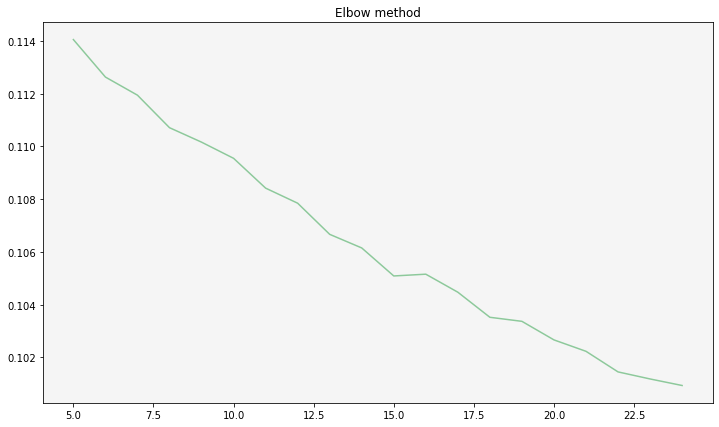

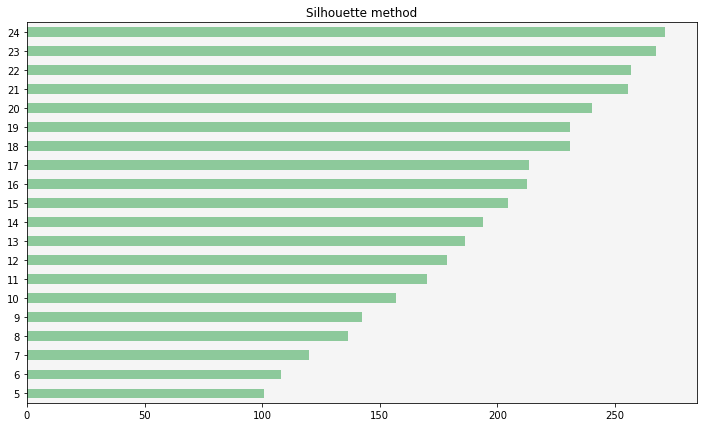

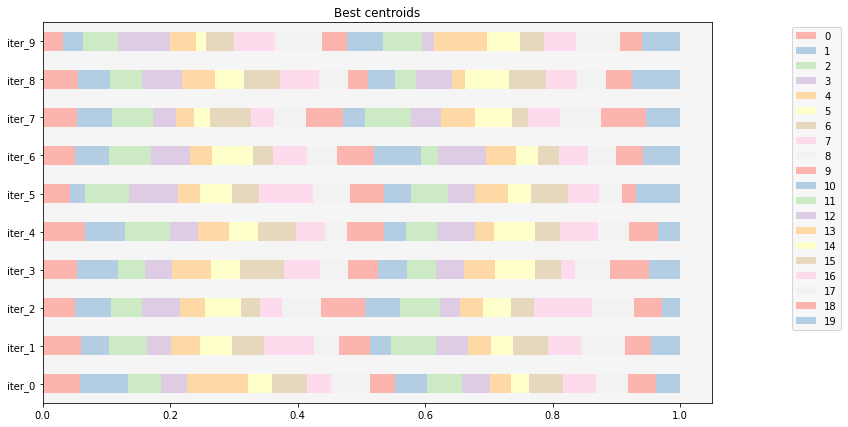

In [233]:
optimal_centroids, optimal_k = fn.optimize(matrix_array,10)

In [234]:
clusters, centroids, n_clusters, WSS = fn.kmeans(optimal_k,matrix_array,optimal_centroids)

By using fewer products (5000), we can see that clusterization is harder to make on few centroids. The silhouette score keeps increasing with increasing values of k meaning that not a good one is obtained with less than 24 clusters. The fact that the clusterization is not optimal on few products is also suggested by the fact that none of the cluster sizes in any of the iteration is significantly larger than the others, which in reality is usually not true.